**Part 1:** 

Use the **Fashion-MNIST** dataset for this question.

1) Load the dataset and perform splitting into training and validation sets with 70:30 ratio.

> Do we need to normalise data? [If so Does it make any difference?]

2) Implement the K Means algorithm. You need to find the optimal number of clusters using the
    elbow method and silhouette method. 

3) Define the initial clusters’ centroids using:</br>
> i) Forgy</br>

> ii) Random Partition

4) Experiment with different distance measures[Euclidean distance, Manhattan distance].

5) Plot the error vs number of clusters graph while using the elbow method and silhouette 
    method. Report the optimal number of clusters found.

6) Report the training and the validation accuracy and Compare your trained model with a model trained by the scikit-learn

7) Visualize the dataset to depict the clusters formed. #Prefer T-SNE

8) Implement K-means++, and repeat task 1 to task 7 again.</br>
</br>
</br>
</br>
</br>


**Part 2:**
</br>
In this task, you will perform operations on [data.csv](https://drive.google.com/file/d/15NPkfXFoTkiRBlcI4ffe_Lp_BFOyf8UY/view?usp=sharing)`[data.csv](https://drive.google.com/file/d/15NPkfXFoTkiRBlcI4ffe_Lp_BFOyf8UY/view?usp=sharing)`, data.csv is a  latent space representation of  Fashion-MNIST, before doing this task please read about latent space representation.

9) Load the data.csv file and apply Kmeans and Kmeans++, You need to find the optimal number of clusters using the elbow method and silhouette method.

10) Visualize the dataset to depict the clusters formed. # Prefer T-SNE

11) From these experiments(Part 1 and Part 2), compare accuracy or error, and report which one is better and why?
</br>
</br>
**Note:** If the model takes a lot of time to train you can use MiniBatchKMeans.
 

In [1]:
import numpy as np
from tqdm.notebook import tqdm

In [21]:
import pandas as pd

In [2]:
from matplotlib import pyplot as plt

In [3]:
from sklearn.metrics import homogeneity_completeness_v_measure, homogeneity_score

In [4]:
def dist(x1,x2,distance):
    x1 = np.array(x1)
    x2 = np.array(x2)
    assert x1.shape == x2.shape
    if distance == 'l2':
        return np.linalg.norm(x1-x2,2)
    if distance == 'l1':
        return np.linalg.norm(x1-x2,1)
    

In [5]:
#implement elbow method from scratch
def elbow(X,y,centers,distance='l2'):
    k = np.unique(y).size
    sq_sum=0
    n = X.shape[0]
    for i in range(n):
        sq_sum+=np.min(np.array([ dist(X[i],centers[j],distance) for j in range(k)]))
    return sq_sum

In [154]:
#implement silhouette method from scratch
def silhouette(X,y,distance='l2'):
    labels = np.unique(y)
    scores = np.zeros(X.shape[0])
    
    distances = np.zeros((X.shape[0],X.shape[0]))
#     pbar = tqdm(total=X.shape[0])
    for idx,x in enumerate(X):
        if distance == 'l2':
            distances[idx] = np.sqrt(np.sum((X-x)**2,axis=1))
        elif distance == 'l1':
            distances[idx] = (np.sum(np.abs(X-x),axis=1))
            
    for xdx,x in enumerate(X):
        a = 0
        bs = np.ones(labels.size) * np.inf
        
        amask = (y==y[xdx])
        A = distances[xdx,amask]
        a = np.sum(A)/(A.shape[0]-1)
        for jdx, jlabel in enumerate(labels):
            if y[xdx] == jdx:
                continue
            bmask = (y==jlabel)
            B = distances[xdx,bmask]
            bs[jdx] = np.sum(B)/B.shape
        b = np.min(bs)
        scores[xdx] = (b-a)/max(a,b)
    return np.mean(scores)

In [7]:
#implement Kmeans from scratch
class Kmeans:
    def __init__(self,k = 2, max_iterations = 100, tolerance = 0.1,distance='l2'):
        self.k = k
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.distance=distance
    def fit(self, X,init='forgy'):
        X = X.copy()
        np.random.shuffle(X)
        if init=='forgy':
            self.centers = X[:self.k]
        else:
            temp_assign = np.random.randint(self.k,size=X.shape[0])
            self.centers = X[:self.k]
            for i in range(self.k):
                self.centers[i] = np.mean(X[temp_assign==i],axis=0)
        
        for iter_n in range(self.max_iterations):
            self.new_close = list(range(self.k))
            
            for i in range(self.k):
                self.new_close[i] = []
                
            for x in X:
                closest = np.argmin(np.array([ dist(x,self.centers[i],self.distance) for i in range(self.k)]))
                self.new_close[closest].append(x)
                
            self.new_centers = self.centers.copy()
            
            for i in range(self.k):
                self.new_centers[i] = np.mean(np.array(self.new_close[i]),axis = 0)

            cf = 0
            for i in range(self.k):
                if dist(self.new_centers[i],self.centers[i],self.distance) > self.tolerance:
                    cf = 1
                
            self.centers = self.new_centers.copy()        
            if not cf:
                break
                
    def predict(self, X):
        n = X.shape[0]
        labels = np.zeros(X.shape[0])
        for i in range(n):
            labels[i] = np.argmin(np.array([ dist(X[i],self.centers[j],self.distance) for j in range(self.k)]))
        return labels
    
    def inertia(self,X):
        sq_sum=0
        n = X.shape[0]
        for i in range(n):
            sq_sum+=np.min(np.array([ dist(X[i],self.centers[j],self.distance) for j in range(self.k)]))
        return sq_sum

In [8]:
#implement Kmeans++ from scratch
class Kmeansplusplus:
    def __init__(self,k = 2, max_iterations = 100, tolerance = 0.1,distance='l2'):
        self.k = k
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.distance=distance
        self.limited = False
    def fit(self, X,init='forgy'):
        X = X.copy()
        np.random.shuffle(X)

        if init=='forgy':
            self.centers = X[:self.k]
        else:
            temp_assign = np.random.randint(self.k,size=X.shape[0])
            self.centers = X[:self.k]
            for i in range(1): #rest will have to be reselected anyways
                self.centers[i] = np.mean(X[temp_assign==i],axis=0)
        
        for curr_center in range(1,self.k):
            dists = np.zeros(X.shape[0])
            for ind,x in enumerate(X):
                dists[ind] = np.max(np.array([ dist(x,self.centers[i],self.distance) for i in range(curr_center)]))
            self.centers[curr_center] = X[np.random.choice(X.shape[0],p = dists/np.sum(dists))]
#             self.centers[curr_center] = X[np.argmax(dists)]

        for iter_n in range(self.max_iterations):
            self.new_close = list(range(self.k))
            
            for i in range(self.k):
                self.new_close[i] = []
                
            for x in X:
                closest = np.argmin(np.array([ dist(x,self.centers[i],self.distance) for i in range(self.k)]))
                self.new_close[closest].append(x)
                
            self.new_centers = self.centers.copy()
            
            for i in range(self.k):
                if np.array(self.new_close[i]).size>0:
                    self.new_centers[i] = np.mean(np.array(self.new_close[i]),axis = 0)
                else:
                    self.limited=True

            cf = 0
            for i in range(self.k):
                if dist(self.new_centers[i],self.centers[i],self.distance) > self.tolerance:
                    cf = 1
                
            self.centers = self.new_centers.copy()        
            if not cf:
                break
        if self.limited:
            print('Using less centers')
                
    def predict(self, X):
        n = X.shape[0]
        labels = np.zeros(X.shape[0])
        for i in range(n):
            labels[i] = np.argmin(np.array([ dist(X[i],self.centers[j],self.distance) for j in range(self.k)]))
        return labels
    
    def inertia(self,X):
        sq_sum=0
        n = X.shape[0]
        for i in range(n):
            sq_sum+=np.min(np.array([ dist(X[i],self.centers[j],self.distance) for j in range(self.k)]))
        return sq_sum        

In [9]:
from keras.datasets import fashion_mnist
(trainX, trainy), (testX, testy) = fashion_mnist.load_data()

In [10]:
trainX = trainX.reshape((-1,28*28))
trainX.shape

(60000, 784)

In [11]:
testX = testX.reshape((-1,28*28))
testX.shape

(10000, 784)

In [13]:
trainX = np.vstack([trainX,testX])

In [17]:
trainy = np.append(trainy,testy)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score

**Answer**: Normalization usually depends on the data. According to few experiments(sorry deleted, will take a lot of time to re run), the results were better with normalization.

Although generally for KMeans, A better approach is to standardize data, so that some features don't dominate others.

However, since the question was about normalization, proceeding with normalization only and not standardization

In [15]:
normalizer = Normalizer()
trainX = normalizer.fit_transform(trainX)
testX = normalizer.transform(testX)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(trainX,trainy,test_size=0.3,random_state=42)

In [19]:
kmeans = Kmeans(k=4,distance='l2')
kmeans.fit(X_train)

In [20]:
silhouette(X_val,kmeans.predict(X_val))

0.17355596300229714

In [70]:
elbow(X_val,kmeans.predict(X_val),kmeans.centers)

9212.474771528154

In [34]:
kmeans = Kmeans(k=4,distance='l2')
kmeans.fit(X_train,init='random-part')

In [35]:
silhouette(X_val,kmeans.predict(X_val))

0.17039851790639524

In [36]:
elbow(X_val,kmeans.predict(X_val),kmeans.centers)

8871.112095048662

In [73]:
ks = list(range(2,16))
elbows = list()
for ind,k in enumerate(ks):
    kmeans = Kmeans(k=k,distance='l2')
    kmeans.fit(X_train)
    elbows.append(elbow(X_val,kmeans.predict(X_val),kmeans.centers))
    print(elbows[-1])

9898.719174837066
9576.6393316116
8897.88129968069
8784.808230322884
8609.784653520224
8371.285967602105
8202.817301983436
8083.679083996497
8008.700061195974
8083.104866414425
7971.971682419729
7878.340941048844
7664.734094787548
7663.619606312705


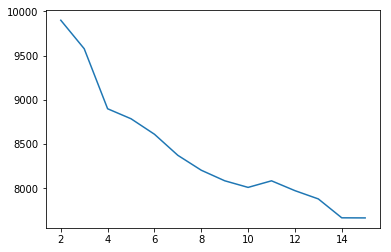

In [75]:
plt.plot(ks,elbows)

The optimal number of clusters seems one of 4 or 10.

In [79]:
ks = list(range(2,16))
shs = list()
for ind,k in enumerate(ks):
    kmeans = Kmeans(k=k,distance='l2')
    kmeans.fit(X_train)
    shs.append(silhouette(X_val,kmeans.predict(X_val)))
    print(shs[-1])

0.2387467711152509
0.212685211977714
0.13025238174215858
0.1165447896946126
0.14212121231857217
0.14765321221980804
0.0902585211035533
0.1170620658796833
0.10276939918595296
0.1147043452258296
0.11652668779394336
0.10951770284235922
0.10524286292508103
0.08674967982064233


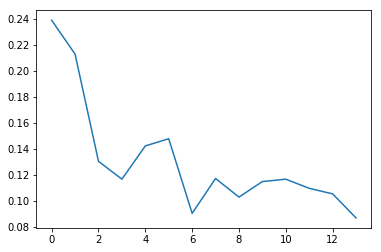

In [80]:
plt.plot(shs)

2 clusters maximizes the sillhoute score (graph is shifted by 2 at x axis)

L1 - Manhattan

In [48]:
kmeans = Kmeans(k=4,distance='l1')
kmeans.fit(X_train)

In [49]:
silhouette(X_val,kmeans.predict(X_val))

0.10763577384224766

In [50]:
elbow(X_val,kmeans.predict(X_val),kmeans.centers)

8955.127615479843

In [51]:
kmeans = Kmeans(k=4,distance='l1')
kmeans.fit(X_train,init='random-part')

In [52]:
silhouette(X_val,kmeans.predict(X_val))

0.15948230431107427

In [53]:
elbow(X_val,kmeans.predict(X_val),kmeans.centers)

8909.512330669073

In [98]:
ks = list(range(2,16))
elbows = list()
for ind,k in enumerate(ks):
    kmeans = Kmeans(k=k,distance='l1')
    kmeans.fit(X_train)
    elbows.append(elbow(X_val,kmeans.predict(X_val),kmeans.centers))
    print(elbows[-1])

9899.544785970791
9220.124314658851
8954.900756274928
8641.42512025473
8468.815592041528
8429.172864851867
8290.727974740419
8218.0369078695
8064.408390510902
8064.232537500469
7958.408110287309
7928.368385170139
7995.267449840022
7859.7255549949705


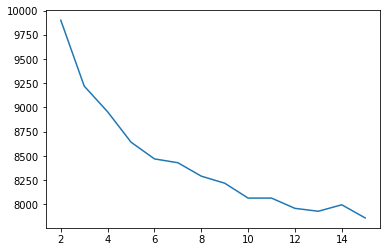

In [99]:
plt.plot(ks,elbows)

The optimal number of clusters seems to be 10.

In [106]:
ks = list(range(2,16))
shs = list()
for ind,k in enumerate(ks):
    kmeans = Kmeans(k=k,distance='l1')
    kmeans.fit(X_train)
    shs.append(silhouette(X_val,kmeans.predict(X_val)))
    print(shs[-1])

0.2333882853780332
0.14773116113578366
0.1594329430219181
0.1559915256891662
0.13991052966587902
0.12408386060181482
0.11912432076219504
0.11565231095136058
0.10891601738905429
0.09116172089023221
0.10013096649390404
0.1000272328357187
0.09818823683706589
0.09325793864066556


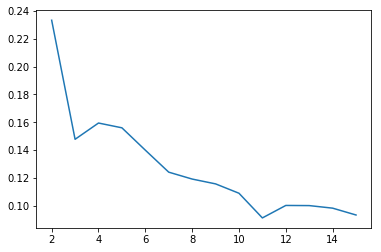

In [107]:
plt.plot(ks,shs)

2 clusters maximizes the sillhoute score

## KMeans++

In [85]:
kmeans = Kmeansplusplus(k=4,distance='l2')
kmeans.fit(X_train)

In [86]:
silhouette(X_val,kmeans.predict(X_val))

0.16187908206723384

In [87]:
elbow(X_val,kmeans.predict(X_val),kmeans.centers)

8901.060786532775

In [41]:
kmeans = Kmeansplusplus(k=4,distance='l2')
kmeans.fit(X_train,init='random-part')

In [42]:
silhouette(X_val,kmeans.predict(X_val))

0.1047050694249616

In [43]:
elbow(X_val,kmeans.predict(X_val),kmeans.centers)

9557.250989083013

In [94]:
ks = list(range(2,16))
elbows = list()
for ind,k in enumerate(ks):
    kmeans = Kmeansplusplus(k=k,distance='l2')
    kmeans.fit(X_train)
    elbows.append(elbow(X_val,kmeans.predict(X_val),kmeans.centers))
    print(elbows[-1])

9949.050978217307
9526.151703017596
8955.579027575457
8719.562718068104
8437.420258755428
8325.417383045053
8161.336599905155
8136.519008178442
8108.482725195422
8111.653400472813
7867.520536300008
7814.408249656854
7845.05235398863
7780.624647233112


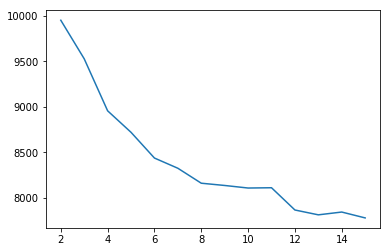

In [95]:
plt.plot(ks,elbows)

The optimal number of clusters seems to be 12.

In [96]:
ks = list(range(2,16))
shs = list()
for ind,k in enumerate(ks):
    kmeans = Kmeansplusplus(k=k,distance='l2')
    kmeans.fit(X_train)
    shs.append(silhouette(X_val,kmeans.predict(X_val)))
    print(shs[-1])

0.15881600160917156
0.1583263131692535
0.18073813597515645
0.14782747539793875
0.12095733195033007
0.12299191361076948
0.10904467469032109
0.1305207117445038
0.11632098004328632
0.11237983624649774
0.12997193206453322
0.09673352980492521
0.1311794767373757
0.10669512356061757


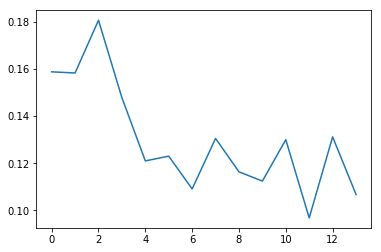

In [97]:
plt.plot(shs)

4 clusters maximizes the sillhoute score (the graph is shifted on x axis by 2)

L1 - Manhattan

In [54]:
kmeans = Kmeansplusplus(k=4,distance='l1')
kmeans.fit(X_train)

In [55]:
silhouette(X_val,kmeans.predict(X_val))

0.15951343683693578

In [56]:
elbow(X_val,kmeans.predict(X_val),kmeans.centers)

8908.51065989013

In [57]:
kmeans = Kmeansplusplus(k=4,distance='l1')
kmeans.fit(X_train,init='random-part')

In [58]:
silhouette(X_val,kmeans.predict(X_val))

0.15947795190991096

In [59]:
elbow(X_val,kmeans.predict(X_val),kmeans.centers)

8909.403499048705

In [101]:
ks = list(range(2,16))
elbows = list()
for ind,k in enumerate(ks):
    kmeans = Kmeansplusplus(k=k,distance='l1')
    kmeans.fit(X_train)
    elbows.append(elbow(X_val,kmeans.predict(X_val),kmeans.centers))
    print(elbows[-1])

9899.577967795409
9219.796029864385
8954.826746607197
8641.36921585455
8590.598751859177
8430.16727860944
8240.29510424638
8134.801330342563
8061.0248484987305
8069.43831416999
8010.632959049939
7928.336049488288
7903.901698855173
8024.159115027679


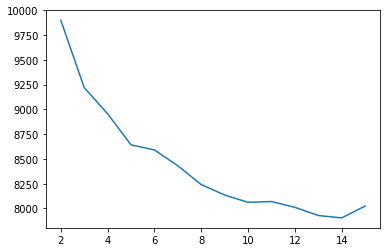

In [102]:
plt.plot(ks,elbows)

The optimal number of clusters seems to be 12.

In [108]:
ks = list(range(2,16))
shs = list()
for ind,k in enumerate(ks):
    kmeans = Kmeansplusplus(k=k,distance='l1')
    kmeans.fit(X_train)
    shs.append(silhouette(X_val,kmeans.predict(X_val)))
    print(shs[-1])

0.23337199331117173
0.14767895873595024
0.15948230431107427
0.1559970203114565
0.14861790575624145
0.13121614349582336
0.11705427421018103
0.10141576453169483
0.11507184205079413
0.10490121666785913
0.09967223671052779
0.08325923850756824
0.09643503850108692
0.09397237800763074


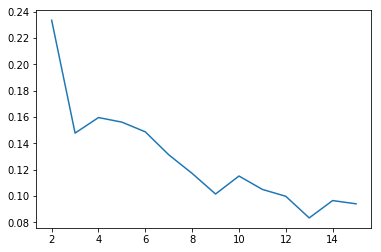

In [109]:
plt.plot(ks,shs)

2 clusters maximizes the sillhoute score

## Sklearn

In [14]:
from sklearn.cluster import KMeans

In [114]:
ks = list(range(2,16))
shs = list()
elbows = list()
for ind,k in enumerate(ks):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_train)
    shs.append(silhouette(X_val,kmeans.predict(X_val)))
    elbows.append(elbow(X_val,kmeans.predict(X_val),kmeans.cluster_centers_))
    print(elbows[-1],shs[-1])

9898.73240196601 0.2341306141299999
9214.55890780433 0.15911322065477929
8843.083602521025 0.1681665969773551
8526.600469343122 0.14920135300122622
8374.218435073954 0.14482770039863785
8219.082337886906 0.15019777097728138
8099.7401549534725 0.15264397897934243
7965.293698386829 0.1478931252568809
7890.109919193299 0.14334981265526
7790.834443958257 0.11761056825560855
7693.285855929229 0.11759054898991003
7641.036630635973 0.11464597667454189
7584.7937037306065 0.11045007601786078
7558.792044775394 0.11288983716349707


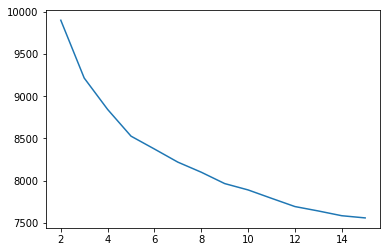

In [115]:
plt.plot(ks,elbows)

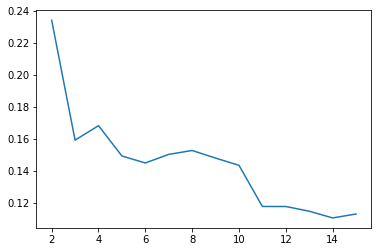

In [116]:
plt.plot(ks,shs)

### Observation results:
- Not much noticable differences in Kmeansplusplus and in-built sklearn KMeans outputs for near optimal K values such as 2 and 4, with respect to silhoutte score.

- However, in-built KMeans performed better overall.

- Kmeansplusplus performed better than Kmeans.

- No explicitly noticable elbows in any model, however increasing SSE loss in some K values in scratch written functions might suggest K-1 as possible elbow.

## Scores

### Sklearn

In [66]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X_train)
y_preds = kmeans.predict(X_val)

In [68]:
homogeneity_completeness_v_measure(y_val,y_preds)

(0.585943711310078, 0.6260308465287788, 0.6053243201140439)

In [69]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_train)
y_preds = kmeans.predict(X_val)

In [70]:
homogeneity_completeness_v_measure(y_val,y_preds)

(0.38375038936753725, 0.66037680617683, 0.48541951130298056)

### KMeans

In [71]:
kmeans = Kmeans(k=10,distance='l1')
kmeans.fit(X_train,init='random-part')
y_preds = kmeans.predict(X_val)

In [72]:
homogeneity_completeness_v_measure(y_val,y_preds)

(0.5298141698236456, 0.594027277897629, 0.5600862465609784)

In [73]:
kmeans = Kmeans(k=10,distance='l2')
kmeans.fit(X_train,init='random-part')
y_preds = kmeans.predict(X_val)

In [74]:
homogeneity_completeness_v_measure(y_val,y_preds)

(0.5523777928487343, 0.6249469637459698, 0.586425831186959)

In [75]:
kmeans = Kmeans(k=10,distance='l1')
kmeans.fit(X_train,init='forgy')
y_preds = kmeans.predict(X_val)

In [76]:
homogeneity_completeness_v_measure(y_val,y_preds)

(0.5322974391486652, 0.6231854512755151, 0.5741669090520013)

In [77]:
kmeans = Kmeans(k=10,distance='l2')
kmeans.fit(X_train,init='forgy')
y_preds = kmeans.predict(X_val)

In [78]:
homogeneity_completeness_v_measure(y_val,y_preds)

(0.5220379088814644, 0.5777018201450462, 0.5484611352769738)

### KMeansplusplus

In [79]:
kmeans = Kmeansplusplus(k=10,distance='l1')
kmeans.fit(X_train,init='random-part')
y_preds = kmeans.predict(X_val)

In [80]:
homogeneity_completeness_v_measure(y_val,y_preds)

(0.5229638387130805, 0.5962410280863121, 0.5572036114137824)

In [81]:
kmeans = Kmeansplusplus(k=10,distance='l2')
kmeans.fit(X_train,init='random-part')
y_preds = kmeans.predict(X_val)

In [82]:
homogeneity_completeness_v_measure(y_val,y_preds)

(0.5071498143217551, 0.5535680501363988, 0.5293432744899454)

In [83]:
kmeans = Kmeansplusplus(k=10,distance='l1')
kmeans.fit(X_train,init='forgy')
y_preds = kmeans.predict(X_val)

In [84]:
homogeneity_completeness_v_measure(y_val,y_preds)

(0.52540963572599, 0.5897210197970578, 0.5557108571214013)

In [85]:
kmeans = Kmeansplusplus(k=10,distance='l2')
kmeans.fit(X_train,init='forgy')
y_preds = kmeans.predict(X_val)

In [86]:
homogeneity_completeness_v_measure(y_val,y_preds)

(0.5960278989249528, 0.6277412866549893, 0.6114736742224968)

## T-SNE for all 3 methods for K = 4

In [116]:
from sklearn.manifold import TSNE

In [17]:
X = TSNE(n_components=2, n_jobs=-1).fit_transform(X_train)

In [117]:
from matplotlib import cm

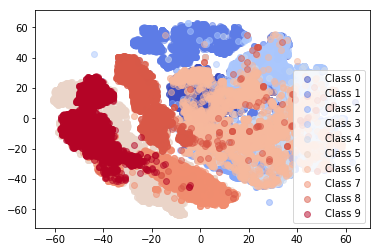

In [25]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 10))
for this_y, color in zip(range(10), colors):
    this_X = X[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

In [28]:
kmeans = Kmeans(k=4,distance='l2')
kmeans.fit(X_train)
y_preds = kmeans.predict(X_train)

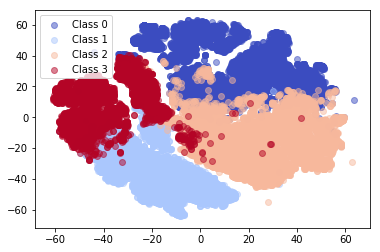

In [29]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 4))
for this_y, color in zip(range(10), colors):
    A = X[y_preds == this_y]
    plt.scatter(A[:, 0], A[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

In [37]:
kmeans = Kmeans(k=4,distance='l2')
kmeans.fit(X_train,init='random-part')
y_preds = kmeans.predict(X_train)

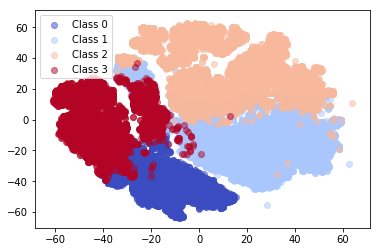

In [38]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 4))
for this_y, color in zip(range(10), colors):
    A = X[y_preds == this_y]
    plt.scatter(A[:, 0], A[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

In [20]:
kmeans = Kmeansplusplus(k=4,distance='l2')
kmeans.fit(X_train)
y_preds = kmeans.predict(X_train)

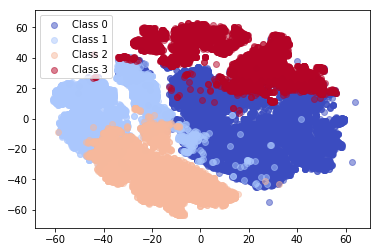

In [27]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 4))
for this_y, color in zip(range(10), colors):
    A = X[y_preds == this_y]
    plt.scatter(A[:, 0], A[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

In [39]:
kmeans = Kmeansplusplus(k=4,distance='l2')
kmeans.fit(X_train,init='random-part')
y_preds = kmeans.predict(X_train)

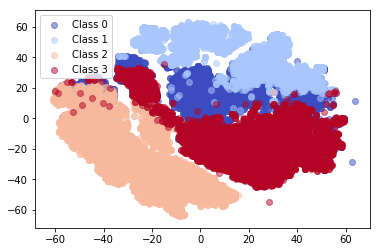

In [40]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 4))
for this_y, color in zip(range(10), colors):
    A = X[y_preds == this_y]
    plt.scatter(A[:, 0], A[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

In [30]:
kmeans = Kmeans(k=4,distance='l1')
kmeans.fit(X_train)
y_preds = kmeans.predict(X_train)

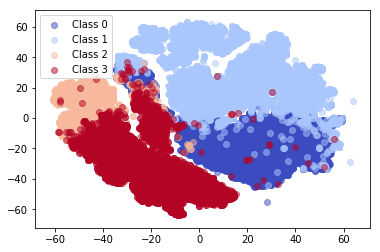

In [31]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 4))
for this_y, color in zip(range(10), colors):
    A = X[y_preds == this_y]
    plt.scatter(A[:, 0], A[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

In [60]:
kmeans = Kmeans(k=4,distance='l1')
kmeans.fit(X_train,init='random-part')
y_preds = kmeans.predict(X_train)

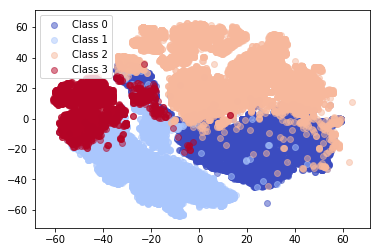

In [45]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 4))
for this_y, color in zip(range(10), colors):
    A = X[y_preds == this_y]
    plt.scatter(A[:, 0], A[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

In [32]:
kmeans = Kmeansplusplus(k=4,distance='l1')
kmeans.fit(X_train)
y_preds = kmeans.predict(X_train)

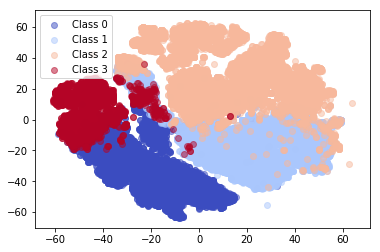

In [33]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 4))
for this_y, color in zip(range(10), colors):
    A = X[y_preds == this_y]
    plt.scatter(A[:, 0], A[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

In [46]:
kmeans = Kmeansplusplus(k=4,distance='l1')
kmeans.fit(X_train,init='random-part')
y_preds = kmeans.predict(X_train)

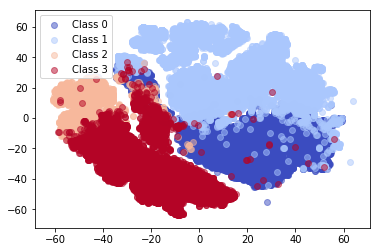

In [47]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 4))
for this_y, color in zip(range(10), colors):
    A = X[y_preds == this_y]
    plt.scatter(A[:, 0], A[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

# Part 2

In [24]:
df = pd.read_csv('data.csv',header=None)

In [25]:
df

,0,1,2,3,4,5,6,7,8,9,...,183,184,185,186,187,188,189,190,191,192
0,[1.0866963863372803,2.371966,5.534521,3.771174,1.877307,3.599094,5.784208,3.871398,2.878446,4.109515,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],Ankle Boot
1,[5.086210250854492,3.526383,3.173435,3.100720,4.561333,4.389340,3.113444,2.403284,4.039598,5.388708,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],T-Shirt
2,[1.211804747581482,2.946491,2.014766,0.606742,1.302111,2.517385,1.538354,0.719057,1.375769,2.441072,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],T-Shirt
3,[3.1817357540130615,3.386448,1.852063,1.134460,2.596234,3.389648,1.662953,1.038565,2.676021,3.362122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],Dress
4,[3.5364575386047363,5.801409,3.549685,1.483723,3.400284,6.017810,3.560772,0.938271,3.958203,6.236764,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],T-Shirt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,[0.011476174928247929,0.059515,0.469514,1.194045,0.512581,0.107612,0.759934,1.375888,2.015975,0.665791,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],Sandal
59996,[2.134517192840576,6.054185,4.831404,1.715127,2.063895,5.509420,4.753547,1.759201,1.910486,5.196002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],Trouser
59997,[5.573720455169678,6.370377,4.076251,1.958915,5.387075,6.138871,4.519176,1.817328,4.937860,6.034277,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],Dress
59998,[2.1300206184387207,1.250919,1.189124,1.248351,2.066808,1.304677,1.205101,1.238864,1.706910,1.652737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],T-Shirt


In [31]:
y_labels = df[192]

In [33]:
all_labels, y = np.unique(y_labels,return_inverse=True)

In [37]:
X = df.drop([192],axis=1)

In [41]:
X.to_numpy().shape

(60000, 192)

In [52]:
X[191] = X[191].apply(lambda x: np.float(x.replace(']','')))

In [53]:
X[0] = X[0].apply(lambda x: np.float(x.replace('[','')))

In [59]:
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=42)

In [64]:
normalizer = Normalizer()
train_X = normalizer.fit_transform(train_X)
test_X = normalizer.transform(test_X)

In [65]:
kmeans = Kmeans(k=4,distance='l2')
kmeans.fit(train_X)

In [66]:
silhouette(test_X,kmeans.predict(test_X))

0.3331360539146866

In [67]:
elbow(test_X,kmeans.predict(test_X),kmeans.centers)

3649.5657125277066

### KMeans

In [68]:
kmeans = Kmeans(k=4,distance='l2')
kmeans.fit(train_X,init='random-part')

In [69]:
silhouette(test_X,kmeans.predict(test_X))

0.23178939107156132

In [70]:
elbow(test_X,kmeans.predict(test_X),kmeans.centers)

3816.5537611357113

In [71]:
ks = list(range(2,16))
elbows = list()
shs = list()
for ind,k in enumerate(ks):
    kmeans = Kmeans(k=k,distance='l2')
    kmeans.fit(train_X)
    elbows.append(elbow(test_X,kmeans.predict(test_X),kmeans.centers))
    shs.append(silhouette(test_X,kmeans.predict(test_X)))
    print(elbows[-1],shs[-1])

4625.764558023988 0.3592962053241806
4321.68650761288 0.22548484279692887
3742.752302139351 0.2465889192634181
3453.2395646647 0.2542518103157337
3428.643575033028 0.2180632577231641
3357.385313676762 0.19276667056926475
3468.5530881116615 0.1620734180946476
3258.347162930697 0.21098979977885576
2988.297683908658 0.24437708900440677
2928.7561272918515 0.27098602576872755
2822.1491362718375 0.20002108376137698
2869.498035945512 0.195951036921996
2836.4180005204003 0.2156175310229445
2797.95331587599 0.19160945341668462


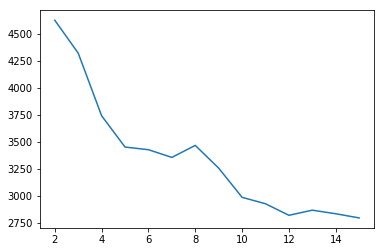

In [72]:
plt.plot(ks,elbows)

The optimal number of clusters seems to be 5.

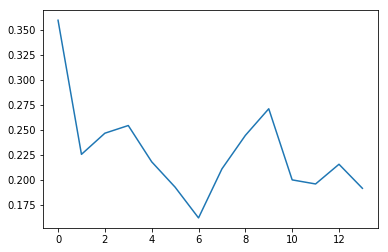

In [73]:
plt.plot(shs)

2 clusters maximizes the sillhoute score (graph is shifted by 2 at x axis)

ALthough 9 clusters also looks good

L1 - Manhattan

In [102]:
kmeans = Kmeans(k=5,distance='l1')
kmeans.fit(train_X)

In [103]:
silhouette(test_X,kmeans.predict(test_X))

0.2323900298198327

In [104]:
elbow(test_X,kmeans.predict(test_X),kmeans.centers)

3645.3965778386378

In [105]:
kmeans = Kmeans(k=5,distance='l1')
kmeans.fit(train_X,init='random-part')

In [106]:
silhouette(test_X,kmeans.predict(test_X))

0.2529090117421308

In [107]:
elbow(test_X,kmeans.predict(test_X),kmeans.centers)

3441.4997936905897

In [80]:
ks = list(range(2,16))
elbows = list()
shs = list()
for ind,k in enumerate(ks):
    kmeans = Kmeans(k=k,distance='l1')
    kmeans.fit(train_X)
    elbows.append(elbow(test_X,kmeans.predict(test_X),kmeans.centers))
    shs.append(silhouette(test_X,kmeans.predict(test_X)))
    print(elbows[-1],shs[-1])

4630.931896965031 0.3522971436996104
3955.4417246791395 0.32818154129076405
3653.235561516076 0.32859161617128596
3510.0625844363153 0.33981797132419667
3356.1033721867507 0.3091745921295027
3158.676345903934 0.25576962025210204
3103.078214228761 0.2341470150733534
3039.323097634075 0.2586728571051695
2889.2821432148644 0.2738872920278163
2860.0307514829237 0.23098626997914234
2791.885608134906 0.2385413007505055
2837.2388508662375 0.18322224807099727
2719.366628579191 0.2323528736748758
2682.143293690878 0.1927675382450932


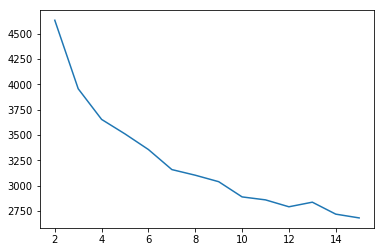

In [81]:
plt.plot(ks,elbows)

The optimal number of clusters seems to be 7.

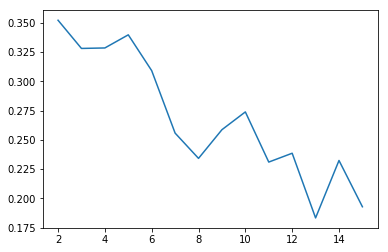

In [82]:
plt.plot(ks,shs)

5 clusters seems to be optimal with respect to the sillhoute score

## KMeans++

In [99]:
kmeans = Kmeansplusplus(k=5,distance='l2')
kmeans.fit(train_X,init='random-part')

In [100]:
silhouette(test_X,kmeans.predict(test_X))

0.302156873906095

In [101]:
elbow(test_X,kmeans.predict(test_X),kmeans.centers)

3472.0632244541193

In [86]:
ks = list(range(2,16))
elbows = list()
shs = list()
for ind,k in enumerate(ks):
    kmeans = Kmeansplusplus(k=k,distance='l2')
    kmeans.fit(train_X)
    elbows.append(elbow(test_X,kmeans.predict(test_X),kmeans.centers))
    shs.append(silhouette(test_X,kmeans.predict(test_X)))
    print(elbows[-1],shs[-1])

4632.1970299527575 0.35437462336725384
4363.782071916513 0.31974656157743103
3762.0508182755843 0.31045499778987257
3500.231771470287 0.2921456631605071
3513.8871630383937 0.2327516454171461
3349.6957795798085 0.21606719187659207
3178.7217396795245 0.21211350208174434
3127.772849322956 0.20311362773864947
3118.2660774314277 0.18270637121052566
2911.0383656148024 0.2230432934388851
2975.827080626228 0.20220057087155016
2835.4667621502954 0.20130368566830797
2859.5676572039465 0.20582337376258217
2766.6717673074177 0.17726420571014526


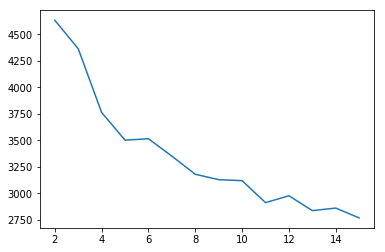

In [87]:
plt.plot(ks,elbows)

The optimal number of clusters seems to be 5.

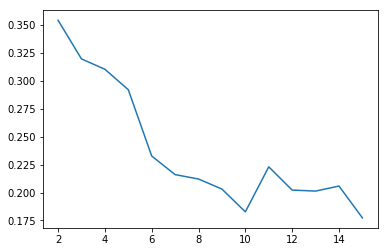

In [93]:
plt.plot(ks,shs)

2 clusters maximizes the sillhoute score

L1 - Manhattan

In [89]:
kmeans = Kmeansplusplus(k=4,distance='l1')
kmeans.fit(train_X)

In [90]:
silhouette(test_X,kmeans.predict(test_X))

0.28339319845893846

In [91]:
elbow(test_X,kmeans.predict(test_X),kmeans.centers)

3781.6191096573284

In [94]:
kmeans = Kmeansplusplus(k=4,distance='l1')
kmeans.fit(train_X,init='random-part')

In [95]:
silhouette(test_X,kmeans.predict(test_X))

0.24413805780401288

In [96]:
elbow(test_X,kmeans.predict(test_X),kmeans.centers)

3748.190182072416

In [97]:
ks = list(range(2,16))
elbows = list()
shs = list()
for ind,k in enumerate(ks):
    kmeans = Kmeansplusplus(k=k,distance='l1')
    kmeans.fit(train_X)
    elbows.append(elbow(test_X,kmeans.predict(test_X),kmeans.centers))
    shs.append(silhouette(test_X,kmeans.predict(test_X)))
    print(elbows[-1],shs[-1])

4626.592294762191 0.35450481676020146
3957.3619266848104 0.3262413777940499
3651.008037581645 0.3302286681165609
3451.2401311598687 0.24830905849443277
3327.083150834861 0.2556916848241228
3175.4651758457444 0.2544206719281217
3061.629230637782 0.26143950216816
3000.37039720849 0.242861012370835
2946.1998354356533 0.2515446276356622
2863.6264894035266 0.24662855029905373
2917.113738048866 0.2302444175985434
2859.6086213410654 0.22847554556378333
2791.1691618104383 0.22749091134168567
2685.2336051680854 0.21074109645281372


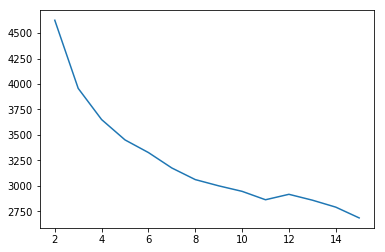

In [98]:
plt.plot(ks,elbows)

The optimal number of clusters seems to be 11.

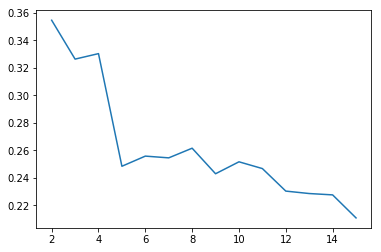

In [108]:
plt.plot(ks,shs)

2 clusters maximizes the sillhoute score.

But 4 seems good number of clusters

- Proceeding with KMeans++ with 4, 5, 7 and 10 clusters Manhattan distance

## Scores

In [114]:
ks = [4,5,7,10]
for k in ks:
    kmeans = Kmeansplusplus(k=k,distance='l1')
    kmeans.fit(train_X,init='random-part')
    y_preds = kmeans.predict(test_X)
    print(k,silhouette(test_X,y_preds),homogeneity_completeness_v_measure(test_y,y_preds))

4 0.3308988940991501 (0.3854685503185122, 0.6921111704242681, 0.49515981859568375)
5 0.2496198557158729 (0.44026289415751835, 0.644358406512081, 0.5231081055675361)
7 0.2810272662345303 (0.49405791912160213, 0.6770458508183326, 0.5712557209552427)
10 0.26634042645049705 (0.5884587759059999, 0.625121421510004, 0.6062363035877674)


### Observations:
- Highest completeness score and silhouette score observed for k=4.

- However as the labels in given dataset are already 10, it is observing highest homogeneity score.

- Highest V-measure (equivalent to F1 score) is observed in k=10.


- For k=10 too, the best results are achieved for KMeans++ with Manhattan distance for random partition initialization of the first center. (all other centers will be initialized according to KMeans++ initialization)

## T-SNE

In [118]:
X_tsne = TSNE(n_components=2, n_jobs=-1).fit_transform(train_X)

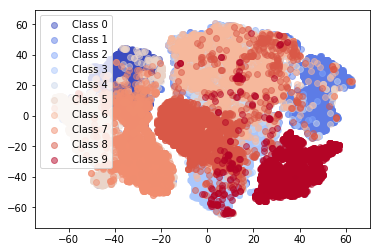

In [121]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 10))
for this_y, color in zip(range(10), colors):
    this_X = X_tsne[train_y == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

In [122]:
kmeans = Kmeansplusplus(k=4,distance='l1')
kmeans.fit(train_X,init='random-part')
y_preds = kmeans.predict(train_X)

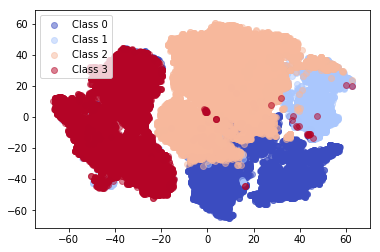

In [124]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 4))
for this_y, color in zip(range(10), colors):
    this_X = X_tsne[y_preds == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

In [127]:
kmeans = Kmeansplusplus(k=5,distance='l1')
kmeans.fit(train_X,init='random-part')
y_preds = kmeans.predict(train_X)

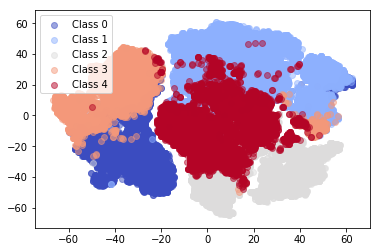

In [128]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 5))
for this_y, color in zip(range(10), colors):
    this_X = X_tsne[y_preds == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

In [125]:
kmeans = Kmeansplusplus(k=7,distance='l1')
kmeans.fit(train_X,init='random-part')
y_preds = kmeans.predict(train_X)

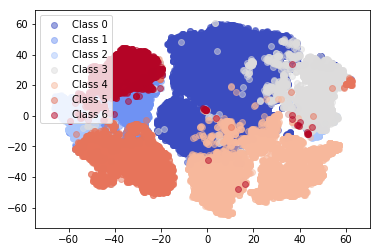

In [126]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 7))
for this_y, color in zip(range(10), colors):
    this_X = X_tsne[y_preds == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

In [129]:
kmeans = Kmeansplusplus(k=10,distance='l1')
kmeans.fit(train_X,init='random-part')
y_preds = kmeans.predict(train_X)

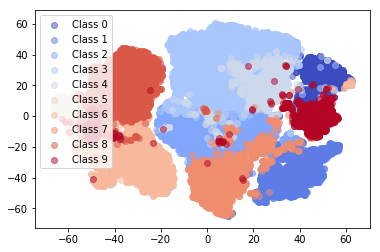

In [131]:
colors = cm.coolwarm(np.linspace(0.0, 1.0, 10))
for this_y, color in zip(range(10), colors):
    this_X = X_tsne[y_preds == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1],
                c=color[np.newaxis, :],
                alpha=0.5,
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.show()

In [133]:
silhouette(train_X,y_preds)

0.2715714297651591

In [151]:
temp = np.random.choice(train_X.shape[0],size=5000,replace=True)

In [152]:
silhouette(train_X[temp],y_preds[temp])

0.2727951324447482

In [153]:
silhouette(train_X[temp],y_preds[temp])

0.2727951324521544